In [6]:
import numpy as np
from scipy.spatial import Delaunay
from matplotlib import pyplot as plt
from scipy.spatial import ConvexHull
from tqdm.auto import tqdm

from collections import deque
from typing import List
from typing import Sequence

In [7]:
#this function creates and retunrs an adjacency matrix by taking the triangle list
def get_adj_mtx(tri, N):
    adj = np.zeros((N, N))
    for triangle in tri:
        adj[triangle[0], triangle[1]] = 1
        adj[triangle[1], triangle[0]] = 1
        adj[triangle[0], triangle[2]] = 1
        adj[triangle[2], triangle[0]] = 1
        adj[triangle[1], triangle[2]] = 1
        adj[triangle[2], triangle[1]] = 1
    return adj

In [8]:
points = np.array([[0, 0], [0, 1.1], [1, 0], [1, 1], [0.6, 0.2]])
tri = Delaunay(points)

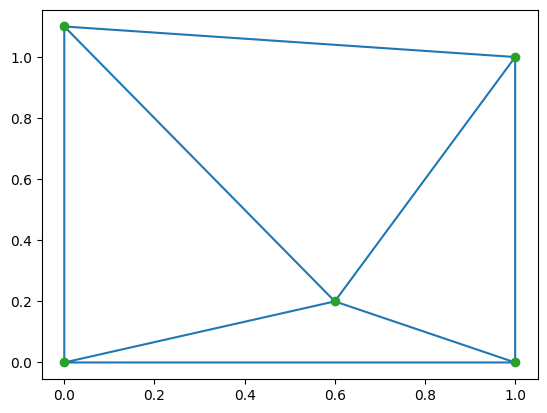

In [9]:
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o');

In [10]:
get_adj_mtx(tri.simplices, 5)

array([[0., 1., 1., 0., 1.],
       [1., 0., 0., 1., 1.],
       [1., 0., 0., 1., 1.],
       [0., 1., 1., 0., 1.],
       [1., 1., 1., 1., 0.]])

## Randomly sample 20 points in [0, 1]^2 and then Do Dealauney

0.0006029605865478516


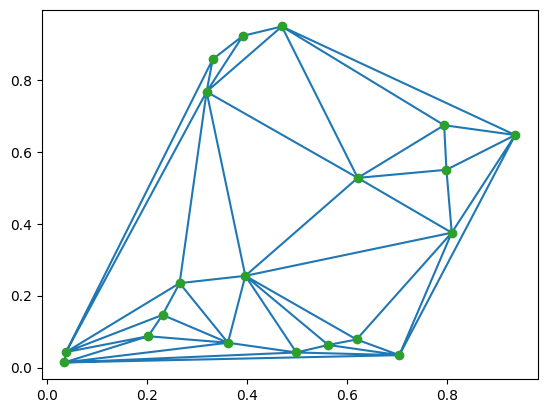

In [11]:
points = np.random.rand(20, 2)
import time
s = time.time()
tri = Delaunay(points)
e = time.time()
print(e-s)
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

In [12]:
time_list = []
for i in range(1000):
    points = np.random.rand(2000, 2)
    s = time.time()
    tri = Delaunay(points)
    e = time.time()
    time_list.append(e-s)
print("Average time: ", sum(time_list)/len(time_list))

Average time:  0.0027774224281311034


In [13]:
def sample_delauney(N=20, randomize_start=False):
    points = np.random.rand(N, 2)
    tri = Delaunay(points).simplices
    adj = get_adj_mtx(tri, N)

    DFSorder = dfs_order(adj, 0)
    
    #reorder the datas
    points = points[DFSorder]
    adj = adj[np.ix_(DFSorder, DFSorder)]
    
    N = len(DFSorder)
    inverse_map = np.empty(N, dtype=int)
    
    for new_idx, old_idx in enumerate(DFSorder):
        inverse_map[old_idx] = new_idx
    tri = inverse_map[tri]
    
    #create the dual graph
    tri_adj = np.zeros((tri.shape[0], tri.shape[0]))
    for i in range(len(tri)):
        for j in range(i, len(tri)):
            if len(np.intersect1d(tri[i], tri[j])) > 1:
                tri_adj[i][j] = 1
                tri_adj[j][i] = 1

    # Compute the convex hull
    hull = ConvexHull(points)
    # Indices of the points forming the convex hull (in counter-clockwise order)
    hull_indices = hull.vertices

    boundary_tri = find_boundary_triangles(tri, hull_indices)

    if not randomize_start:
        #dfs traversal of the dual graph
        tri_dfs_order = dfs_order(tri_adj, boundary_tri[0])
        #reorder the points and triangles
        tri = tri[tri_dfs_order]
        ##add the stop sign to tri
        tri = np.vstack((tri, [N, N, N]))  
        return points, adj, tri
    else:
        tri_list = []
        for i in range(len(boundary_tri)):
            #dfs traversal of the dual graph
            tri_dfs_order = dfs_order(tri_adj, boundary_tri[i])
            #reorder the points and triangles
            tri_i = tri[tri_dfs_order]
            ##add the stop sign to tri
            tri_i = np.vstack((tri_i, [N, N, N])) 
            tri_list.append(tri_i)
        return points, adj, tri_list

def dfs_order(adj_matrix, start_index) -> list:
    """
    Perform a Depth-First Search (DFS) over the graph (with adjacency matrix adj_matrix),
    returning the order in which nodes are first visited.

    Args:
        adj_matrix: np.ndarray of shape (N, N), adjacency matrix of the graph.
                    - adj_matrix[u, v] != 0 means an edge from u to v.
                    - No self-connections => diag(adj_matrix) = 0.
        start_indices: the index of the starting triangle

    Returns:
        A list of node indices in the order they are visited by DFS.
        If the graph is disconnected, the DFS restarts from the next unvisited node
        until all nodes are covered.
    """
    N = adj_matrix.shape[0]
    visited = [False] * N
    dfs_visit_order = []

    def dfs_iter(start_node: int):
        stack = [start_node]
        while stack:
            node = stack.pop()
            if not visited[node]:
                visited[node] = True
                dfs_visit_order.append(node)
                # Push neighbors in reverse order so that lower-index neighbors
                # are popped/visited first (this is optional, just for deterministic ordering).
                neighbors = []
                for neighbor in range(N):
                    if adj_matrix[node, neighbor] != 0 and not visited[neighbor]:
                        neighbors.append(neighbor)
                # Reverse the neighbor list so that we visit them in ascending order
                for n in reversed(neighbors):
                    stack.append(n)

    # Run DFS from each unvisited node (this covers all components if graph is disconnected)
    dfs_iter(start_index)

    return dfs_visit_order

def bfs_order(adj_matrix, start_index):
    """
    Perform a Breadth‑First Search (BFS) over a graph given its adjacency matrix,
    returning the order in which nodes are first visited.

    Parameters
    ----------
    adj_matrix : np.ndarray, shape (N, N)
        Adjacency matrix of the graph.  Non‑zero entry adj_matrix[u, v] means an
        edge from node u to node v.  Diagonal is assumed to be zero
        (no self‑loops).
    start_index : int
        Index of the node from which BFS starts.

    Returns
    -------
    visit_order : List[int]
        A list of node indices in the order they are *first* visited by BFS.
        (If you need a complete traversal of *all* components, call this
        function separately for each disconnected component.)
    """
    if adj_matrix.ndim != 2 or adj_matrix.shape[0] != adj_matrix.shape[1]:
        raise ValueError("`adj_matrix` must be a square 2‑D array.")
    if not (0 <= start_index < adj_matrix.shape[0]):
        raise IndexError("`start_index` out of range.")

    N = adj_matrix.shape[0]
    visited = [False] * N
    visit_order: List[int] = []

    queue = deque([start_index])
    visited[start_index] = True

    while queue:
        node = queue.popleft()
        visit_order.append(node)

        # Collect unvisited neighbours, sorted for deterministic order
        neighbours = [
            nbr for nbr in range(N)
            if adj_matrix[node, nbr] != 0 and not visited[nbr]
        ]

        for nbr in neighbours:
            visited[nbr] = True
            queue.append(nbr)

    return visit_order

def find_boundary_triangles(tri, hull_indices):
    n = len(hull_indices)
    boundary_sides = [(hull_indices[i], hull_indices[(i+1)%n]) for i in range(n)]

    results = []

    for side in boundary_sides:
        p1, p2 = side
        # Find triangles containing both p1 and p2
        mask = np.array([
            (p1 in triangle) and (p2 in triangle)
            for triangle in tri
        ])
        matched_tri_indices = np.where(mask)[0][0]
        results.append(matched_tri_indices)

    return results

In [14]:
points, adj, tri = sample_delauney(N=20)

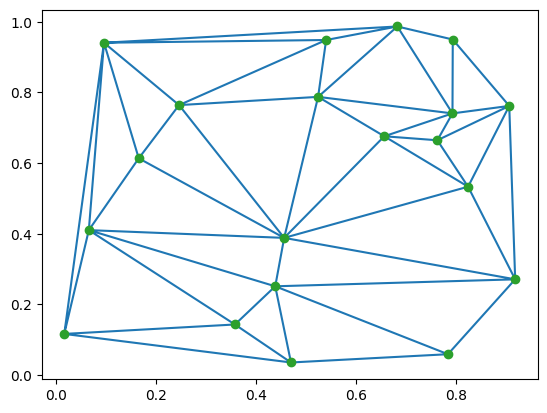

In [15]:
plt.triplot(points[:,0], points[:,1], tri[:-1]);
plt.plot(points[:,0], points[:,1], 'o');

In [18]:
points, adj, tri_list = sample_delauney(N=20, randomize_start=True)

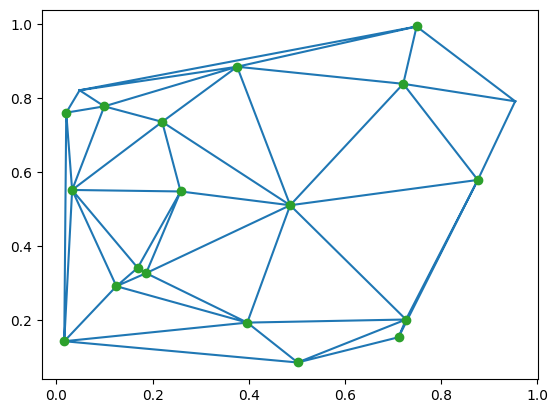

In [19]:
plt.triplot(points[:,0], points[:,1], tri_list[3][:29]);
i = 18
plt.plot(points[:,0][:i], points[:,1][:i], 'o');

In [20]:
def build_dataset(num_samples=10000, N=20, seed=42, padding_len=35, padding_val=-1, order=False):
    """
    Build a dataset of (points, adjacency) pairs for GNN training.
    
    Parameters
    ----------
    num_samples : int
        How many samples you want in your dataset.
    N : int
        Number of points per sample.
    seed : int
        Random seed for reproducibility.
    order: bool
        whether to order the indices in the triangles
        
    Returns
    -------
    X : np.ndarray
        Shape (num_samples, N, 2), each row is the set of 2D points.
    Y : np.ndarray
        Shape (num_samples, N, N), each corresponding adjacency matrix
    TRI: np.ndarray
        Shape (num_samples, padding_len, 3)
    """
    # Optional: Set the random seed for reproducibility
    np.random.seed(seed)
    
    # Preallocate arrays
    X = np.zeros((num_samples, N, 2), dtype=np.float32)
    Y = np.zeros((num_samples, N, N), dtype=np.float32)
    TRI = np.zeros((num_samples, padding_len, 3), dtype=np.int32)
    
    for i in range(num_samples):
        points, adj, tri = sample_delauney(N=N)
        if order:
            tri = np.sort(tri, axis=1)
        
        X[i] = points
        Y[i] = adj
        
        N_tri = tri.shape[0]
        if N_tri > padding_len:
            raise ValueError(f"Input has {N_tri} rows, which exceeds the target length {padding_len}.")
            
        pad_rows = padding_len - N_tri
        padding = np.full((pad_rows, 3), padding_val, dtype=tri.dtype)
        tri = np.vstack([tri, padding])
        TRI[i] = tri
            
    
    return X, Y, TRI

def build_dataset_randomized(num_samples=10000, N=20, seed=42, padding_len=35, padding_val=-1, order=False):
    '''
    Basically the same as before, but the data set will be larger
    the traversal order of triangles will be different, with randomized starting boundary triangles

    Parameters
    ----------
    num_samples : int
        How many samples you want in your dataset.
    N : int
        Number of points per sample.
    seed : int
        Random seed for reproducibility.
    order: bool
        whether to order the indices in the triangles
        
    Returns
    -------
    X : np.ndarray
        Shape (unknown_num_samples, N, 2), each row is the set of 2D points.
    Y : np.ndarray
        Shape (unknown_num_samples, N, N), each corresponding adjacency matrix.
    TRI: np.ndarray
        Shape (unknwon_num_samples, padding_len, 3)
    '''
    
    # Optional: Set the random seed for reproducibility
    np.random.seed(seed)
    
    #container
    X = []
    Y = []
    TRI = []
    
    for i in tqdm(range(num_samples)):
        points, adj, tri_list = sample_delauney(N=N, randomize_start=True)
        tri_list = np.array(tri_list)
        if order:
            tri_list = np.sort(tri_list, axis=2)

        for k in range(tri_list.shape[0]):
            X.append(points)
            Y.append(points)
        
            N_tri = tri_list[k].shape[0]
            if N_tri > padding_len:
                raise ValueError(f"Input has {N_tri} rows, which exceeds the target length {padding_len}.")
            
            pad_rows = padding_len - N_tri
            padding = np.full((pad_rows, 3), padding_val, dtype=tri_list.dtype)
            tri = np.vstack([tri_list[k], padding])
            TRI.append(tri)
    return np.array(X), np.array(Y), np.array(TRI)


In [21]:
X, Y, TRI = build_dataset(num_samples=10000, N=20, seed=123, order=True)
print("X shape:", X.shape)  # (10000, 20, 2)
print("Y shape:", Y.shape)  # (10000, 20, 20)
print("TRI shape:", TRI.shape) # (10000, 35, 3)

X shape: (10000, 20, 2)
Y shape: (10000, 20, 20)
TRI shape: (10000, 35, 3)


In [575]:
np.savez("dataset_xytri_10000_ordered.npz", X=X, Y=Y, tri=TRI)

In [576]:
data = np.load("dataset_xytri_10000_ordered.npz")
X_loaded = data["X"]
Y_loaded = data["Y"]
tri_loaded = data['tri']

In [577]:
##create a test dataset
X, Y, TRI = build_dataset(num_samples=2000, N=20, seed=321, order=True)
print("X shape:", X.shape)  # (10000, 20, 2)
print("Y shape:", Y.shape)  # (10000, 20, 20)
print("TRI shape:", TRI.shape) # (10000, 35, 3)

X shape: (2000, 20, 2)
Y shape: (2000, 20, 20)
TRI shape: (2000, 35, 3)


In [578]:
np.savez("testset_xytri_2000_ordered.npz", X=X, Y=Y, tri=TRI)

In [733]:
#create randomized training dataset 
X, Y, TRI = build_dataset_randomized(num_samples=10000, N=20, seed=321, order=True)
print("X shape:", X.shape)  
print("Y shape:", Y.shape)  
print("TRI shape:", TRI.shape) 

  0%|          | 0/10000 [00:00<?, ?it/s]

X shape: (77438, 20, 2)
Y shape: (77438, 20, 2)
TRI shape: (77438, 35, 3)


In [734]:
np.savez("dataset_xytri_10000_ordered_random.npz", X=X, Y=Y, tri=TRI)

In [739]:
##create a test dataset of smaller N = 10
X, Y, TRI = build_dataset(num_samples=2000, N=10, seed=42, order=True, padding_len=16)
print("X shape:", X.shape)  # (10000, 20, 2)
print("Y shape:", Y.shape)  # (10000, 20, 20)
print("TRI shape:", TRI.shape) # (10000, 35, 3)

np.savez("testset_xytri_2000_N10_ordered_random.npz", X=X, Y=Y, tri=TRI)

X shape: (2000, 10, 2)
Y shape: (2000, 10, 10)
TRI shape: (2000, 16, 3)


In [25]:
def build_knn_graph(points, k = 5):
    """
    Build a k‑nearest‑neighbour (k‑NN) graph for 2‑D points and return its adjacency matrix.

    Parameters
    ----------
        points : np.ndarray, shape (N, 2)
            Array of N points in the plane, one per row.
        k      : int, default=5
            Number of nearest neighbours each node is connected to
            (excluding the point itself).

    Returns
    -------
    adj : np.ndarray, shape (N, N)
        Binary (0/1) adjacency matrix.  adj[i, j] == 1 means point *i*
        is connected to point *j*.  The matrix is symmetric.
    """
    if k < 1:
        raise ValueError("k must be a positive integer.")
    if points.ndim != 2 or points.shape[1] != 2:
        raise ValueError("`points` must have shape (N, 2).")

    N = points.shape[0]
    
    diff = points[:, None, :] - points[None, :, :]
    dist2 = np.einsum("ijk,ijk->ij", diff, diff)    #

    np.fill_diagonal(dist2, np.inf)

    knn_idx = np.argpartition(dist2, kth=k, axis=1)[:, :k]   # shape (N, k)

    adj = np.zeros((N, N), dtype=np.uint8)
    rows = np.repeat(np.arange(N), k)
    cols = knn_idx.reshape(-1)
    adj[rows, cols] = 1
    adj |= adj.T  

    return adj

def plot_knn_graph(points, adj, index=None):
    """
    Visualise a k‑NN graph with Matplotlib.

    Parameters
    ----------
    points : np.ndarray, shape (N, 2)
        2‑D coordinates of N nodes.
    adj    : np.ndarray, shape (N, N)
        Binary adjacency matrix returned by `build_knn_graph`.
        Non‑zero entry adj[i, j] means an edge between i and j.
    """
    if points.ndim != 2 or points.shape[1] != 2:
        raise ValueError("`points` must have shape (N, 2).")
    if adj.shape[0] != adj.shape[1] or adj.shape[0] != points.shape[0]:
        raise ValueError("`adj` must be a square matrix with the same number of rows as `points`.")

    N = points.shape[0]

    fig, ax = plt.subplots()
    ax.scatter(points[:, 0], points[:, 1], s=40, color="tab:blue", zorder=3)

    # draw each edge once (i < j to avoid duplicates)
    for i in range(N):
        for j in range(i + 1, N):
            if adj[i, j]:
                ax.plot(
                    [points[i, 0], points[j, 0]],
                    [points[i, 1], points[j, 1]],
                    color="lightgray",
                    linewidth=1,
                    zorder=1,
                )

    ax.set_aspect("equal")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("k‑NN graph")

    if index is not None:
        ax.scatter(points[:, 0][:index], points[:, 1][:index], color='red', zorder=10)


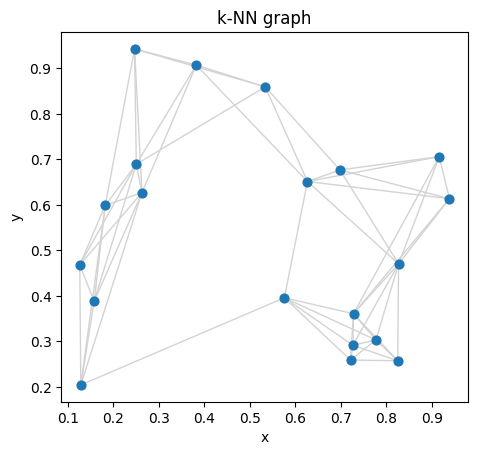

In [1515]:
N = 20

points = np.random.rand(N, 2)

adj = build_knn_graph(points)
plot_knn_graph(points, adj)
plt.savefig("KNN_graph.png", dpi=300)

In [1512]:
#dfs order
DFSorder = dfs_order(adj, 0)

#reorder the datas
points_dfs = points[DFSorder]
adj_dfs = adj[np.ix_(DFSorder, DFSorder)]


#bfs order
BFSorder = bfs_order(adj, 0)

#reorder the datas
points_bfs = points[BFSorder]
adj_bfs = adj[np.ix_(BFSorder, BFSorder)]


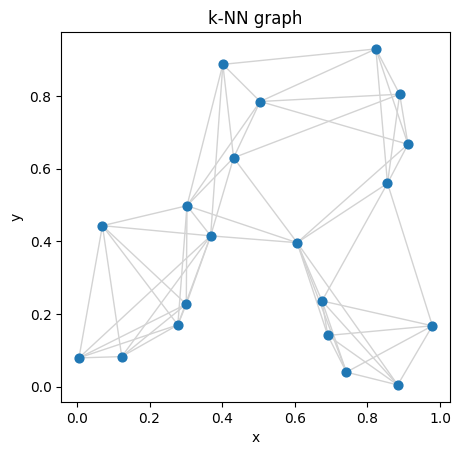

In [1077]:
plot_knn_graph(points_bfs, adj_bfs)

In [1122]:
# Compute the convex hull
hull = ConvexHull(points)
# Indices of the points forming the convex hull (in counter-clockwise order)
hull_indices = hull.vertices

print(hull_indices)

#use one of the hull_indices as starting point to traverse the nodes, and triangles
starting_index = hull_indices[1]

#dfs order
DFSorder = dfs_order(adj, starting_index)

#reorder the datas
points_dfs = points[DFSorder]
adj_dfs = adj[np.ix_(DFSorder, DFSorder)]


#bfs order
BFSorder = bfs_order(adj, starting_index)

#reorder the datas
points_bfs = points[BFSorder]
adj_bfs = adj[np.ix_(BFSorder, BFSorder)]

[ 1 15 11  2  7  8  4 17]


In [1123]:
tri = Delaunay(points_bfs).simplices
delaunay_adj = get_adj_mtx(tri, N)

#create the dual graph
tri_adj = np.zeros((tri.shape[0], tri.shape[0]))
for i in range(len(tri)):
    for j in range(i, len(tri)):
        if len(np.intersect1d(tri[i], tri[j])) > 1:
            tri_adj[i][j] = 1
            tri_adj[j][i] = 1



In [1135]:
bfs_hull = ConvexHull(points_bfs).vertices

nonzero_hull_values = [v for v in bfs_hull if v != 0] 
rows = np.where((tri == 0).any(axis=1) & np.isin(tri, nonzero_hull_values).any(axis=1))[0] #indices of rows that are neigh bor 0

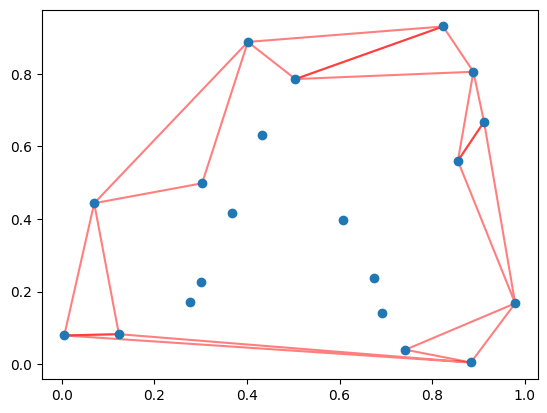

In [1164]:
chosen = []
for i in bfs_hull:
    nonzero_hull_values = [v for v in bfs_hull if v != i]
    rows = np.where((tri == i).any(axis=1) & np.isin(tri, nonzero_hull_values).any(axis=1))[0] #indices of rows that are neigh bor 0

    choice = rows[0]
    if choice in chosen:
        choice = rows[1]
    chosen.append(choice)
    plt.triplot(points_bfs[:,0], points_bfs[:,1], tri[[choice]], c='red', alpha=0.5);


plt.plot(points_bfs[:,0], points_bfs[:,1], 'o');

In [22]:
import numpy as np
from collections import deque
from typing import Sequence

def is_connected(points, adj_matrix) -> bool:
    """
    Check in O(N + E) time whether an undirected graph is connected.

    Parameters
    ----------
    points : np.ndarray, shape (N, 2)
        Coordinates of N 2‑D points (only used to sanity‑check N).
    adj_matrix : np.ndarray, shape (N, N)
        Adjacency matrix (non‑zero ⇒ edge).  Assumed symmetric
        and with zero diagonal.

    Returns
    -------
    connected : bool
        True  → every node is reachable from every other node  
        False → the graph has ≥ 2 connected components
    """
    if points.ndim != 2 or points.shape[1] != 2:
        raise ValueError("`points` must have shape (N, 2).")
    if adj_matrix.shape[0] != adj_matrix.shape[1]:
        raise ValueError("`adj_matrix` must be square.")
    if adj_matrix.shape[0] != points.shape[0]:
        raise ValueError("`points` and `adj_matrix` disagree on N.")

    N = adj_matrix.shape[0]
    if N <= 1:
        return True          # empty / single‑node graph is trivially connected

    visited = np.zeros(N, dtype=bool)
    queue = deque([0])
    visited[0] = True

    while queue:
        u = queue.popleft()
        # fast NumPy lookup of neighbours
        nbrs = np.nonzero(adj_matrix[u])[0]
        unvisited = nbrs[~visited[nbrs]]
        visited[unvisited] = True
        queue.extend(unvisited.tolist())

        if visited.all():    # early exit: all nodes reached
            return True

    return False             # some nodes never reached
    

def sample_delauney_new(N=20, order=bfs_order, k=5, train=True):
    
    ##generate N random nodes in 2d, arbitrary orders and make sure the knn graph is connected
    points = np.random.rand(N, 2)
    #create the KNN graph and find its adjacency matrix
    adj = build_knn_graph(points, k=k)

    while not is_connected(points, adj):
        print("Encountered Disconnected KNN graph for k = ", k)
        points = np.random.rand(N, 2)
        #create the KNN graph and find its adjacency matrix
        adj = build_knn_graph(points, k=k)
    
    #find the convex hull of these points
    hull = ConvexHull(points).vertices
    
    #build the dual graph of triangles using the old index
    tri = Delaunay(points).simplices
    delaunay_adj = get_adj_mtx(tri, N)
    
    #create the dual graph
    tri_adj = np.zeros((tri.shape[0], tri.shape[0]))
    for i in range(len(tri)):
        for j in range(i, len(tri)):
            if len(np.intersect1d(tri[i], tri[j])) > 1:
                tri_adj[i][j] = 1
                tri_adj[j][i] = 1
    
    #starting from each hull point do bfs and reorder the points, then delaunay on the reordered points 
    order_func = order
    chosen = []
    points_list = []
    tri_list = []
    for i in hull:
        #order of indices
        order = order_func(adj, i)
        
        #order these delaunay triangles 
        #first of all find a starting point for those triangles 
        nonzero_hull_values = [v for v in hull if v != i]
        
        rows = np.where((tri == i).any(axis=1) & np.isin(tri, nonzero_hull_values).any(axis=1))[0] #indices of rows that are neigh bor i
        #choose a starting triangle that is on the boundary, neighbors i, and not chosen before 
        choice = rows[0]
        if choice in chosen and len(rows) > 1:
            choice = rows[1]
        chosen.append(choice)

        #order the triangle staring from the choisen starting point
        order_tri = order_func(tri_adj, choice)
    
        #reorder points
        points_reordered = points[order]
        #reorder the triangles
        tri_reordered = tri[order_tri]
        #replace the indices in the tri sequence by the new indices 
        #old to new index dictionary 
        dict = {}
        for i, val in enumerate(order):
            dict[val] = i
        try:
            tri_reordered = np.sort(np.vectorize(dict.__getitem__)(tri_reordered), axis=1)
            tri_reordered = np.vstack((tri_reordered, [N, N, N]))
        except:
            plot_knn_graph(points, adj)
    
        points_list.append(points_reordered)
        tri_list.append(tri_reordered)
    if train:
        return points_list, tri_list
    else:
        return [points_list[0]], [tri_list[0]]

def build_dataset_new(num_samples=10000, N=20, seed=42, padding_len=35, padding_val=-1, order=bfs_order, k=5, train=True):
    # Optional: Set the random seed for reproducibility
    np.random.seed(seed)
    
    #container
    X = []
    TRI = []
    
    for i in tqdm(range(num_samples)):
        points_list, tri_list = sample_delauney_new(N=N, order=order, k=k, train=train)
        tri_list = np.array(tri_list)

        for j in range(tri_list.shape[0]):
            X.append(points_list[j])
        
            N_tri = tri_list[j].shape[0]
            if N_tri > padding_len:
                raise ValueError(f"Input has {N_tri} rows, which exceeds the target length {padding_len}.")
            
            pad_rows = padding_len - N_tri
            padding = np.full((pad_rows, 3), padding_val, dtype=tri_list.dtype)
            tri = np.vstack([tri_list[j], padding])
            TRI.append(tri)
    return np.array(X), np.array(TRI)

In [26]:
X, TRI = build_dataset_new(num_samples=10000, N=20, seed=41, padding_len=35, padding_val=-1, order=bfs_order, k=5)
print(X.shape)
print(TRI.shape)

  0%|          | 0/10000 [00:00<?, ?it/s]

Encountered Disconnected KNN graph for k =  5
Encountered Disconnected KNN graph for k =  5
Encountered Disconnected KNN graph for k =  5
Encountered Disconnected KNN graph for k =  5
Encountered Disconnected KNN graph for k =  5
Encountered Disconnected KNN graph for k =  5
Encountered Disconnected KNN graph for k =  5
Encountered Disconnected KNN graph for k =  5
Encountered Disconnected KNN graph for k =  5
Encountered Disconnected KNN graph for k =  5
Encountered Disconnected KNN graph for k =  5
Encountered Disconnected KNN graph for k =  5
Encountered Disconnected KNN graph for k =  5
Encountered Disconnected KNN graph for k =  5
Encountered Disconnected KNN graph for k =  5
Encountered Disconnected KNN graph for k =  5
Encountered Disconnected KNN graph for k =  5
Encountered Disconnected KNN graph for k =  5
Encountered Disconnected KNN graph for k =  5
Encountered Disconnected KNN graph for k =  5
Encountered Disconnected KNN graph for k =  5
Encountered Disconnected KNN graph

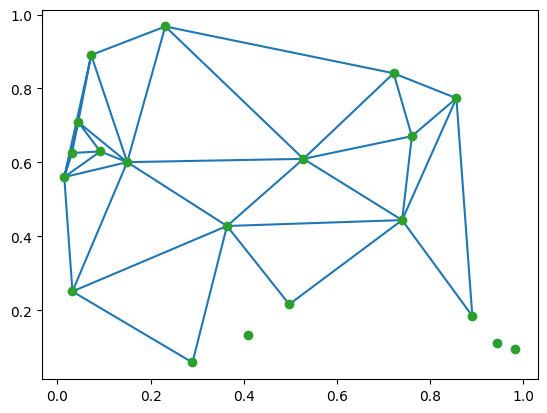

In [39]:
i = 22
plt.triplot(X[i][:,0], X[i][:,1], TRI[i][:20]);
plt.plot(X[i][:,0], X[i][:,1], 'o');

In [1497]:
np.savez("train_10000_bfs_k5_N20.npz", X=X, tri=TRI)

In [40]:
X, TRI = build_dataset_new(num_samples=5000, N=15, seed=43, padding_len=25, padding_val=-1, order=bfs_order, k=5, train=False)
print(X.shape)
print(TRI.shape)

  0%|          | 0/5000 [00:00<?, ?it/s]

Encountered Disconnected KNN graph for k =  5
Encountered Disconnected KNN graph for k =  5
Encountered Disconnected KNN graph for k =  5
Encountered Disconnected KNN graph for k =  5
(5000, 15, 2)
(5000, 25, 3)


In [1626]:
np.savez("test_5000_bfs_k5_N15.npz", X=X, tri=TRI)

In [41]:
data = np.load("train_10000_bfs_k5_N20.npz")
X_loaded = data['X']
tri_loaded = data['tri']

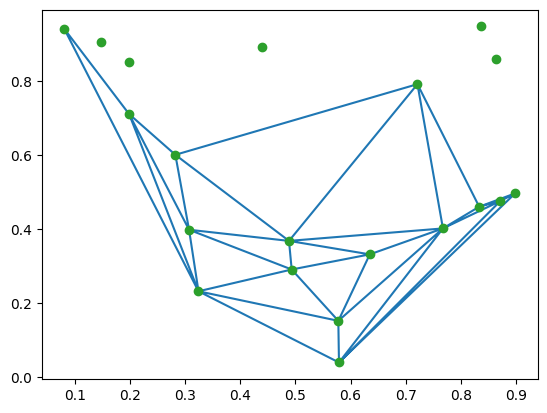

In [1628]:
i = 1203
plt.triplot(X_loaded[i][:,0], X_loaded[i][:,1], tri_loaded[i][:20]);
plt.plot(X_loaded[i][:,0], X_loaded[i][:,1], 'o');

In [1569]:
points_list, tri_lists, points, adj = sample_delauney_new()

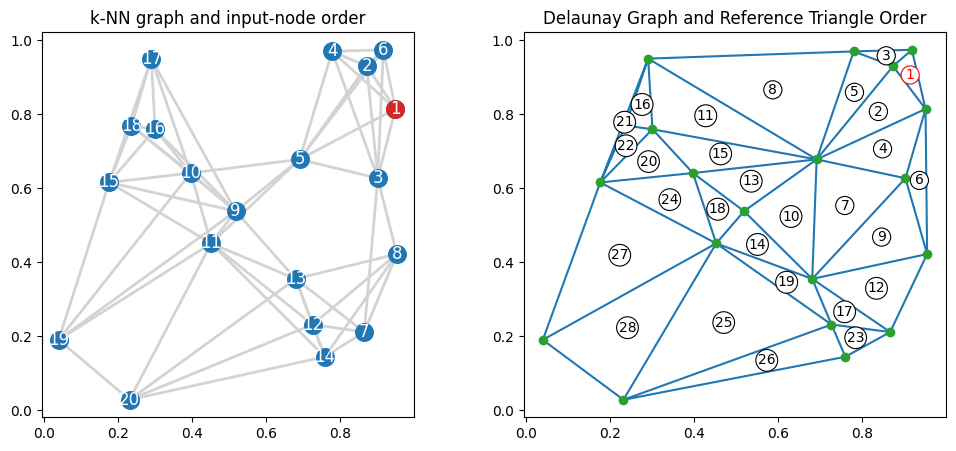

In [1594]:
N = points.shape[0]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# ---------------------------------------------------------------
# (1) k‑NN edges
# ---------------------------------------------------------------
for i in range(N):
    for j in range(i + 1, N):
        if adj[i, j]:
            ax[0].plot([points[i, 0], points[j, 0]],
                       [points[i, 1], points[j, 1]],
                       color="lightgray", linewidth=2, zorder=1)

ax[0].set_aspect("equal")
ax[0].set_title("k‑NN graph and input‑node order")

# ---------------------------------------------------------------
# (2) input nodes + order labels
# ---------------------------------------------------------------
i = 1
ax[0].scatter(points_list[i][:, 0], points_list[i][:, 1],
              s=160, color="tab:blue", zorder=3)

ax[0].scatter(points_list[i][0, 0], points_list[i][0, 1],
              s=160, color="tab:red", zorder=3)

for idx, (x, y) in enumerate(points_list[i]):
    ax[0].text(x, y, str(idx + 1), fontsize=12,
                   ha="center", va="center", color="white", zorder=4)

# ---------------------------------------------------------------
# (3) Delaunay triangulation
# ---------------------------------------------------------------
ax[1].triplot(points_list[i][:, 0], points_list[i][:, 1],
              tri_lists[i][:-1])          # triangle edges
ax[1].plot(points_list[i][:, 0], points_list[i][:, 1], 'o')

# ---------------------------------------------------------------
# (4) triangle‑order labels at centroids
# ---------------------------------------------------------------
tri_indices = tri_lists[i][:-1]           # (T, 3)
coords      = points_list[i]              # (N, 2)
centroids   = coords[tri_indices].mean(axis=1)

for t_id, (cx, cy) in enumerate(centroids):
    if t_id == 0:
        ax[1].text(cx, cy, str(t_id+1), fontsize=10,
               ha="center", va="center", zorder=5, color='red',
               bbox={                      # use literal to avoid shadowed dict()
                   "boxstyle": "circle,pad=0.15",
                   "fc": "white",
                   "ec": "red",
                   "lw": 0.8
               })
    else:
        ax[1].text(cx, cy, str(t_id+1), fontsize=10,
                   ha="center", va="center", zorder=5,
                   bbox={                      # use literal to avoid shadowed dict()
                       "boxstyle": "circle,pad=0.15",
                       "fc": "white",
                       "ec": "black",
                       "lw": 0.8
                   })

ax[1].set_title("Delaunay Graph and Reference Triangle Order");
#plt.savefig("Dataset_plot.png", dpi=400);